In [1]:
import copy
import sys
import os
sys.path.append('/home/kai/DAST/network')
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.autograd import Variable
from DAST_Network import DAST
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from typing import List
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


In [2]:
class DAST_TF(nn.Module):
    def __init__(self, HP, pretrain_model_path, pretrain_model_name):
        super(DAST_TF, self).__init__()
        self.HP = HP
        self.pretrained_model = DAST(self.HP['dim_val_s'], self.HP['dim_attn_s'], self.HP['dim_val_t'], self.HP['dim_attn_t'], self.HP['dim_val'], self.HP['dim_attn'], self.HP['time_step'], self.HP['feature_len'], self.HP['dec_seq_len'], self.HP['output_sequence_length'], self.HP['n_decoder_layers'], self.HP['n_encoder_layers'], self.HP['n_heads'], self.HP['debug'])
        self.pretrained_model.load_state_dict(torch.load(f'{pretrain_model_path}/{pretrain_model_name}.pt'))
        for param in self.pretrained_model.parameters():
            param.requires_grad = False
            
        for param in self.pretrained_model.out_fc.parameters():
            param.requires_grad = True
            
        for param in self.pretrained_model.sensor_enc_input_fc.parameters():
            param.requires_grad = True
            
        # for param in self.pretrained_model.sensor_encoder1.parameters():
        #     param.requires_grad = True
            
        # for param in self.pretrained_model.sensor_encoder2.parameters():
        #     param.requires_grad = True
            
        # for param in self.pretrained_model.sensor_encoder3.parameters():
        #     param.requires_grad = True
            
    def forward(self, x):
        # Forward pass through the pretrained model
        fine_tuned_output = self.pretrained_model(x)
        return fine_tuned_output

In [3]:
class DASTModelTF():
    def __init__(self, train_datasets: List[str], test_dataset: List[str], data_path: str, is_norm: bool, hyper_parameters: dict, model_save_path: str, model_save_name: str, pretrain_path: str, pretrain_model_name: str) -> None:
        self.TRAIN_DATASETS = train_datasets
        self.TEST_DATASETS = test_dataset
        self.DATA_PATH = data_path
        self.MODEL_SAVE_PATH = model_save_path
        self.MODEL_SAVE_NAME = model_save_name
        self.X_train = []
        self.X_test = []
        self.Y_train = []
        self.Y_test = []
        self.HP = hyper_parameters
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.best_predict = []
        self.last_predict_y = None
        self.train_loss_list = []
        self.test_loss_list = []
        self.best_mse_loss = 10000.0
        self.best_rmse_loss = None
        self.best_train_loss = 10000.0
        self.norm = '_norm' if is_norm else ''
        self.pretrain_path = pretrain_path
        self.pretrain_model_name = pretrain_model_name
        self.best_model_params = None
        
    @staticmethod
    def RMSE(target, pred):
        square_error = (target - pred) ** 2
        mse =  (torch.sum(square_error)) / len(target)
        rmse = mse ** 0.5
        return rmse
    
    @staticmethod
    def MAE(target, pred):
        absolute_error = np.abs(target - pred)
        return torch.sum(absolute_error) / len(target)
    
    def _load_x_y(self, folder: str):
        y_tmp = np.load(f'{self.DATA_PATH}/{folder}/{folder}_Y.npy')
        feature1 = np.load(f'{self.DATA_PATH}/{folder}/{folder}_X{self.norm}_2560.npy')
        feature2 = np.load(f'{self.DATA_PATH}/{folder}/{folder}_X{self.norm}_1280.npy')
        feature3 = np.load(f'{self.DATA_PATH}/{folder}/{folder}_X{self.norm}_640.npy')
        X_train = np.concatenate((feature1, feature2, feature3), axis=2)
        return X_train, np.reshape(y_tmp, ((len(y_tmp), -1)))
    
    def _concate(self):
        self.X_train = np.concatenate(self.X_train, axis=0)
        self.Y_train = np.concatenate(self.Y_train, axis=0)
        self.X_test = np.concatenate(self.X_test, axis=0)
        self.Y_test = np.concatenate(self.Y_test, axis=0)

    def _load_np(self,):
        # train
        for folder in self.TRAIN_DATASETS:
            X_train, Y_train = self._load_x_y(folder)
            self.X_train.append(X_train)
            self.Y_train.append(Y_train)
        # test
        for folder in self.TEST_DATASETS:
            X_test, Y_test = self._load_x_y(folder)
            self.X_test.append(X_test)
            self.Y_test.append(Y_test)
        
    def _loop_feature(self, X, selected_indices):
        extracted_values_list = []
        for i in range(7):
            for num in selected_indices:
                extracted_values = X[:, :, num + 16 * i]
                extracted_values_list.append(extracted_values)
        result_array = np.stack(extracted_values_list, axis=-1)
        return result_array
    
    def _select_feature(self, selected_indices):
        for i in range(len(self.X_train)):
            self.X_train[i] = self._loop_feature(self.X_train[i], selected_indices)
        for i in range(len(self.X_test)):
            self.X_test[i] = self._loop_feature(self.X_test[i], selected_indices)
        
    def _tensorizing(self):
        self.X_train = Variable(torch.Tensor(self.X_train).float())
        self.Y_train = Variable(torch.Tensor(self.Y_train).float())
        self.X_test = Variable(torch.Tensor(self.X_test).float())
        self.Y_test = Variable(torch.Tensor(self.Y_test).float())
        
    def _get_dataloader(self):
        train_dataset = TensorDataset(self.X_train, self.Y_train)
        train_loader = DataLoader(dataset=train_dataset, batch_size=self.HP['batch_size'], shuffle=False)
        test_dataset = TensorDataset(self.X_test, self.Y_test)
        test_loader = DataLoader(dataset=test_dataset, batch_size=self.HP['batch_size'], shuffle=False)
        return train_loader, test_loader
    
    def _get_model(self):
        model = DAST_TF(self.HP, self.pretrain_path, self.pretrain_model_name).pretrained_model
        model = model.to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=self.HP['lr'])
        criterion = nn.MSELoss()
        return model, optimizer, criterion

    def train(self, model: DAST_TF, optimizer: torch.optim.Optimizer, criterion, train_loader: DataLoader, epoch: int):
        model.train()
        tmp_loss_list = []
        loop = tqdm(train_loader, leave=True)
        for _, (X, Y) in enumerate(loop):
            batch_X = X.to(self.device)
            batch_Y = Y.to(self.device)
            out = model(batch_X)
            loss = criterion(out, batch_Y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tmp_loss_list.append(loss.item())
        loss_eopch = np.mean(np.array(tmp_loss_list))
        self.train_loss_list.append(loss_eopch)
        if (loss_eopch.item() < self.best_train_loss):
            self.best_train_loss = loss_eopch.item()
        print('epoch = ',epoch,
                'train_loss = ',loss_eopch.item())

    def eval(self, model: DAST_TF, test_loader: DataLoader, criterion, epoch: int):
        model.eval()
        prediction_list = []
        with torch.no_grad():
            for _ ,(batch_x, _) in enumerate(test_loader):
                batch_X = batch_x.to(self.device)
                prediction = model(batch_X)
                prediction_list.append(prediction)

        out_batch_pre = torch.cat(prediction_list).detach().cpu()
        rmse_loss = self.RMSE(self.Y_test, out_batch_pre, )
        mae_loss = self.MAE(self.Y_test, out_batch_pre, )
        test_loss = criterion(out_batch_pre, self.Y_test)
        self.test_loss_list.append(test_loss)
        if (test_loss.item() < self.best_mse_loss):
            self.best_mse_loss = test_loss.item()
            self.best_rmse_loss = rmse_loss.item()
            self.best_predict = np.reshape(out_batch_pre, (-1)).tolist()
            torch.save(model.state_dict(), f'{self.MODEL_SAVE_PATH}/{self.MODEL_SAVE_NAME}.pt')
        print('rmse_loss = ', rmse_loss.item(),
                'mae_loss = ', mae_loss.item(),
                'mse_loss = ', test_loss.item())
        if epoch == self.HP['epochs'] - 1:
            self.last_predict_y = out_batch_pre

    def main(self, selected_indices):
        self._load_np()
        self._select_feature(selected_indices)
        self._concate()
        self._tensorizing()
        print(self.X_train.shape)
        model, optimizer, criterion = self._get_model()
        train_loader, test_loader = self._get_dataloader()
        times = 0
        for epoch in range(self.HP['epochs']):
            start = time.time()
            self.train(model, optimizer, criterion, train_loader, epoch)
            end = time.time()
            times += end - start
            self.eval(model, test_loader, criterion, epoch)
        print(f"train time: {times/100:.7f}, s/epoch")
        print(f"embed1: {self.HP['dim_val_s']}, embed2: {self.HP['dim_attn_s']}, lr: {self.HP['lr']}, dec_seq_len: {self.HP['dec_seq_len']}")
        

In [4]:
DATA_PATH = '../../../data/10FEMTO/processed_data/'
PRETRAIN_MODEL_TYPE = 'Bearing2'
TRAIN_DATASETS = ['Bearing1_1', 'Bearing1_2']
TEST_DATASET = ['Bearing1_3', 'Bearing1_4', 'Bearing1_5', 'Bearing1_6', 'Bearing1_7']
MODEL_SAVE_PATH = '../../../model'
MODEL_SAVE_NAME = f'{PRETRAIN_MODEL_TYPE}_pretrain_Bearing1_finetune'
PRETRAIN_MODEL_PATH = '../../../model'
PRETRAIN_MODEL_NAME = f'{PRETRAIN_MODEL_TYPE}_pretrain'
IS_NORM = False

In [5]:
selected_indices = [1, 3, 5, 7, 9, 10, 14]
# selected_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
FEATURE_LEN = len(selected_indices)
FEATURE_SIZE = 20
EMBEDD = 10
HYPER_PARAMETERS = {
    'batch_size': 256,
    'dim_val': FEATURE_SIZE,
    'dim_attn': EMBEDD,
    'dim_val_t': FEATURE_SIZE,
    'dim_attn_t': EMBEDD,
    'dim_val_s': FEATURE_SIZE,
    'dim_attn_s': EMBEDD,
    'n_heads': 4,
    'n_decoder_layers': 1,
    'n_encoder_layers': 2,
    'lr': 1e-3,
    'epochs': 100,
    'time_step': 40,
    # limit how many last input used, important!
    'dec_seq_len': 6,
    'output_sequence_length': 1,
    'feature_len': FEATURE_LEN,
    'debug': True
}

In [6]:
dast_model = DASTModelTF(train_datasets=TRAIN_DATASETS, test_dataset=TEST_DATASET, data_path=DATA_PATH, is_norm=IS_NORM, hyper_parameters=HYPER_PARAMETERS, model_save_path=MODEL_SAVE_PATH, model_save_name=MODEL_SAVE_NAME, pretrain_path=PRETRAIN_MODEL_PATH, pretrain_model_name=PRETRAIN_MODEL_NAME)

In [7]:
dast_model.main(selected_indices)

torch.Size([3594, 40, 49])


100%|██████████| 15/15 [00:00<00:00, 23.76it/s]


epoch =  0 train_loss =  0.08968047018473348
rmse_loss =  0.3789048194885254 mae_loss =  0.3401932418346405 mse_loss =  0.14356885850429535


100%|██████████| 15/15 [00:00<00:00, 24.26it/s]


epoch =  1 train_loss =  0.11948440068711837
rmse_loss =  0.32352572679519653 mae_loss =  0.28014180064201355 mse_loss =  0.10466889292001724


100%|██████████| 15/15 [00:00<00:00, 22.29it/s]


epoch =  2 train_loss =  0.06831628875806928
rmse_loss =  0.17752589285373688 mae_loss =  0.10317878425121307 mse_loss =  0.031515441834926605


100%|██████████| 15/15 [00:00<00:00, 21.17it/s]


epoch =  3 train_loss =  0.046993073914200066
rmse_loss =  0.32967597246170044 mae_loss =  0.2862716317176819 mse_loss =  0.10868623852729797


100%|██████████| 15/15 [00:00<00:00, 23.69it/s]


epoch =  4 train_loss =  0.06491396920367455
rmse_loss =  0.2019686996936798 mae_loss =  0.12133508920669556 mse_loss =  0.040791355073451996


100%|██████████| 15/15 [00:00<00:00, 25.17it/s]


epoch =  5 train_loss =  0.029886167279134193
rmse_loss =  0.2113407552242279 mae_loss =  0.13066481053829193 mse_loss =  0.044664911925792694


100%|██████████| 15/15 [00:00<00:00, 22.34it/s]


epoch =  6 train_loss =  0.046820185865120344
rmse_loss =  0.25767797231674194 mae_loss =  0.19820132851600647 mse_loss =  0.06639793515205383


100%|██████████| 15/15 [00:00<00:00, 21.88it/s]


epoch =  7 train_loss =  0.03925813804380596
rmse_loss =  0.2010752558708191 mae_loss =  0.11652153730392456 mse_loss =  0.04043126106262207


100%|██████████| 15/15 [00:00<00:00, 25.61it/s]


epoch =  8 train_loss =  0.032673925708513706
rmse_loss =  0.21987077593803406 mae_loss =  0.14122626185417175 mse_loss =  0.04834315925836563


100%|██████████| 15/15 [00:00<00:00, 23.03it/s]


epoch =  9 train_loss =  0.03673462836304679
rmse_loss =  0.22363775968551636 mae_loss =  0.1472242772579193 mse_loss =  0.05001384764909744


100%|██████████| 15/15 [00:00<00:00, 24.28it/s]


epoch =  10 train_loss =  0.032651521156852444
rmse_loss =  0.21259808540344238 mae_loss =  0.12977564334869385 mse_loss =  0.04519794508814812


100%|██████████| 15/15 [00:00<00:00, 26.30it/s]


epoch =  11 train_loss =  0.031916065025143325
rmse_loss =  0.21516381204128265 mae_loss =  0.13235026597976685 mse_loss =  0.04629546403884888


100%|██████████| 15/15 [00:00<00:00, 22.43it/s]


epoch =  12 train_loss =  0.03150966931134462
rmse_loss =  0.21549676358699799 mae_loss =  0.13269062340259552 mse_loss =  0.046438854187726974


100%|██████████| 15/15 [00:00<00:00, 22.63it/s]


epoch =  13 train_loss =  0.030448465856413046
rmse_loss =  0.213511124253273 mae_loss =  0.12922845780849457 mse_loss =  0.045586999505758286


100%|██████████| 15/15 [00:00<00:00, 21.21it/s]


epoch =  14 train_loss =  0.029797095440638563
rmse_loss =  0.2131228744983673 mae_loss =  0.12834741175174713 mse_loss =  0.045421358197927475


100%|██████████| 15/15 [00:00<00:00, 21.99it/s]


epoch =  15 train_loss =  0.02889278663787991
rmse_loss =  0.21158571541309357 mae_loss =  0.12581747770309448 mse_loss =  0.04476851224899292


100%|██████████| 15/15 [00:00<00:00, 22.33it/s]


epoch =  16 train_loss =  0.0287262041393357
rmse_loss =  0.21211066842079163 mae_loss =  0.12632133066654205 mse_loss =  0.044990938156843185


100%|██████████| 15/15 [00:00<00:00, 20.94it/s]


epoch =  17 train_loss =  0.027713327393090972
rmse_loss =  0.2103639394044876 mae_loss =  0.12370160967111588 mse_loss =  0.04425298422574997


100%|██████████| 15/15 [00:00<00:00, 22.53it/s]


epoch =  18 train_loss =  0.027580725424923003
rmse_loss =  0.2104400098323822 mae_loss =  0.12354426831007004 mse_loss =  0.04428499564528465


100%|██████████| 15/15 [00:00<00:00, 26.25it/s]


epoch =  19 train_loss =  0.026723944178471962
rmse_loss =  0.20918259024620056 mae_loss =  0.12173926085233688 mse_loss =  0.0437573567032814


100%|██████████| 15/15 [00:00<00:00, 23.33it/s]


epoch =  20 train_loss =  0.026871988351922484
rmse_loss =  0.2097025215625763 mae_loss =  0.12218555808067322 mse_loss =  0.04397514462471008


100%|██████████| 15/15 [00:00<00:00, 26.03it/s]


epoch =  21 train_loss =  0.025927617916992555
rmse_loss =  0.20867852866649628 mae_loss =  0.12072727829217911 mse_loss =  0.043546728789806366


100%|██████████| 15/15 [00:00<00:00, 21.96it/s]


epoch =  22 train_loss =  0.02616358103308206
rmse_loss =  0.20903025567531586 mae_loss =  0.12088820338249207 mse_loss =  0.043693650513887405


100%|██████████| 15/15 [00:00<00:00, 22.18it/s]


epoch =  23 train_loss =  0.02521711108274758
rmse_loss =  0.20816640555858612 mae_loss =  0.1196868047118187 mse_loss =  0.043333251029253006


100%|██████████| 15/15 [00:00<00:00, 23.35it/s]


epoch =  24 train_loss =  0.02552428008057177
rmse_loss =  0.20846866071224213 mae_loss =  0.11976560205221176 mse_loss =  0.04345918446779251


100%|██████████| 15/15 [00:00<00:00, 21.58it/s]


epoch =  25 train_loss =  0.02460816315530489
rmse_loss =  0.20790256559848785 mae_loss =  0.11897426098585129 mse_loss =  0.04322347790002823


100%|██████████| 15/15 [00:00<00:00, 21.52it/s]


epoch =  26 train_loss =  0.02494995198212564
rmse_loss =  0.20820587873458862 mae_loss =  0.11906872689723969 mse_loss =  0.04334969073534012


100%|██████████| 15/15 [00:00<00:00, 23.17it/s]


epoch =  27 train_loss =  0.024085260702607532
rmse_loss =  0.2078181803226471 mae_loss =  0.11845851689577103 mse_loss =  0.04318839684128761


100%|██████████| 15/15 [00:00<00:00, 23.66it/s]


epoch =  28 train_loss =  0.024394886381924153
rmse_loss =  0.20795993506908417 mae_loss =  0.118393175303936 mse_loss =  0.04324733465909958


100%|██████████| 15/15 [00:00<00:00, 23.63it/s]


epoch =  29 train_loss =  0.02357183168642223
rmse_loss =  0.20764505863189697 mae_loss =  0.11782167106866837 mse_loss =  0.04311647266149521


100%|██████████| 15/15 [00:00<00:00, 23.78it/s]


epoch =  30 train_loss =  0.023836394919392965
rmse_loss =  0.20772221684455872 mae_loss =  0.11769116669893265 mse_loss =  0.04314851760864258


100%|██████████| 15/15 [00:00<00:00, 23.21it/s]


epoch =  31 train_loss =  0.023082506804106135
rmse_loss =  0.20761479437351227 mae_loss =  0.11728594452142715 mse_loss =  0.0431039035320282


100%|██████████| 15/15 [00:00<00:00, 23.26it/s]


epoch =  32 train_loss =  0.02330427199291686
rmse_loss =  0.20771121978759766 mae_loss =  0.11719004809856415 mse_loss =  0.043143950402736664


100%|██████████| 15/15 [00:00<00:00, 22.12it/s]


epoch =  33 train_loss =  0.02261805214608709
rmse_loss =  0.20780611038208008 mae_loss =  0.11693105101585388 mse_loss =  0.04318338260054588


100%|██████████| 15/15 [00:00<00:00, 22.71it/s]


epoch =  34 train_loss =  0.02276415314214925
rmse_loss =  0.2077532857656479 mae_loss =  0.11671081185340881 mse_loss =  0.04316142573952675


100%|██████████| 15/15 [00:00<00:00, 23.06it/s]


epoch =  35 train_loss =  0.022135990757184722
rmse_loss =  0.20784972608089447 mae_loss =  0.11641868203878403 mse_loss =  0.0432015098631382


100%|██████████| 15/15 [00:00<00:00, 23.07it/s]


epoch =  36 train_loss =  0.022198424635765452
rmse_loss =  0.20764264464378357 mae_loss =  0.11605536937713623 mse_loss =  0.043115466833114624


100%|██████████| 15/15 [00:00<00:00, 22.98it/s]


epoch =  37 train_loss =  0.021635050668070713
rmse_loss =  0.20789876580238342 mae_loss =  0.11588708311319351 mse_loss =  0.04322189837694168


100%|██████████| 15/15 [00:00<00:00, 23.62it/s]


epoch =  38 train_loss =  0.02166042848645399
rmse_loss =  0.20769710838794708 mae_loss =  0.1155480444431305 mse_loss =  0.043138086795806885


100%|██████████| 15/15 [00:00<00:00, 22.66it/s]


epoch =  39 train_loss =  0.021158731713270148
rmse_loss =  0.20827612280845642 mae_loss =  0.11564261466264725 mse_loss =  0.04337894171476364


100%|██████████| 15/15 [00:00<00:00, 23.54it/s]


epoch =  40 train_loss =  0.021175746681789558
rmse_loss =  0.2076897919178009 mae_loss =  0.11500544100999832 mse_loss =  0.04313504695892334


100%|██████████| 15/15 [00:00<00:00, 23.28it/s]


epoch =  41 train_loss =  0.02068825998964409
rmse_loss =  0.20864489674568176 mae_loss =  0.11533361673355103 mse_loss =  0.04353269189596176


100%|██████████| 15/15 [00:00<00:00, 22.89it/s]


epoch =  42 train_loss =  0.020838290499523283
rmse_loss =  0.20677438378334045 mae_loss =  0.11368587613105774 mse_loss =  0.042755644768476486


100%|██████████| 15/15 [00:00<00:00, 23.99it/s]


epoch =  43 train_loss =  0.020159112064478298
rmse_loss =  0.20943458378314972 mae_loss =  0.11534006148576736 mse_loss =  0.04386284574866295


100%|██████████| 15/15 [00:00<00:00, 22.78it/s]


epoch =  44 train_loss =  0.02067597721082469
rmse_loss =  0.20823395252227783 mae_loss =  0.11446642875671387 mse_loss =  0.04336138069629669


100%|██████████| 15/15 [00:00<00:00, 23.09it/s]


epoch =  45 train_loss =  0.019719499178851643
rmse_loss =  0.21110478043556213 mae_loss =  0.11648081243038177 mse_loss =  0.04456523060798645


100%|██████████| 15/15 [00:00<00:00, 22.85it/s]


epoch =  46 train_loss =  0.02042819431129222
rmse_loss =  0.20819035172462463 mae_loss =  0.11398813128471375 mse_loss =  0.04334321990609169


100%|██████████| 15/15 [00:00<00:00, 22.22it/s]


epoch =  47 train_loss =  0.018976506241597236
rmse_loss =  0.21012479066848755 mae_loss =  0.11463391780853271 mse_loss =  0.04415242746472359


100%|██████████| 15/15 [00:00<00:00, 23.86it/s]


epoch =  48 train_loss =  0.019794229646989455
rmse_loss =  0.20726363360881805 mae_loss =  0.1126096174120903 mse_loss =  0.04295821115374565


100%|██████████| 15/15 [00:00<00:00, 22.55it/s]


epoch =  49 train_loss =  0.0183587135359024
rmse_loss =  0.20976391434669495 mae_loss =  0.11352124065160751 mse_loss =  0.04400090128183365


100%|██████████| 15/15 [00:00<00:00, 23.17it/s]


epoch =  50 train_loss =  0.01964463839928309
rmse_loss =  0.2072557508945465 mae_loss =  0.1122046485543251 mse_loss =  0.0429549477994442


100%|██████████| 15/15 [00:00<00:00, 22.47it/s]


epoch =  51 train_loss =  0.018137581987927358
rmse_loss =  0.21225175261497498 mae_loss =  0.11556103080511093 mse_loss =  0.04505080357193947


100%|██████████| 15/15 [00:00<00:00, 22.53it/s]


epoch =  52 train_loss =  0.01978071426662306
rmse_loss =  0.20947225391864777 mae_loss =  0.11408205330371857 mse_loss =  0.043878622353076935


100%|██████████| 15/15 [00:00<00:00, 22.94it/s]


epoch =  53 train_loss =  0.0177750001118208
rmse_loss =  0.2140832394361496 mae_loss =  0.1172284185886383 mse_loss =  0.04583163186907768


100%|██████████| 15/15 [00:00<00:00, 23.89it/s]


epoch =  54 train_loss =  0.019226745407407483
rmse_loss =  0.20881296694278717 mae_loss =  0.11294668912887573 mse_loss =  0.04360285773873329


100%|██████████| 15/15 [00:00<00:00, 23.65it/s]


epoch =  55 train_loss =  0.016899233513201276
rmse_loss =  0.21054628491401672 mae_loss =  0.11216532438993454 mse_loss =  0.04432974010705948


100%|██████████| 15/15 [00:00<00:00, 22.89it/s]


epoch =  56 train_loss =  0.018462324103650948
rmse_loss =  0.2051408290863037 mae_loss =  0.10953220725059509 mse_loss =  0.042082756757736206


100%|██████████| 15/15 [00:00<00:00, 23.26it/s]


epoch =  57 train_loss =  0.01648536369514962
rmse_loss =  0.21075443923473358 mae_loss =  0.11152321100234985 mse_loss =  0.04441743344068527


100%|██████████| 15/15 [00:00<00:00, 21.45it/s]


epoch =  58 train_loss =  0.018962922451707224
rmse_loss =  0.20919489860534668 mae_loss =  0.11262784153223038 mse_loss =  0.04376250505447388


100%|██████████| 15/15 [00:00<00:00, 23.55it/s]


epoch =  59 train_loss =  0.016880907816812396
rmse_loss =  0.21910905838012695 mae_loss =  0.12254919111728668 mse_loss =  0.04800878092646599


100%|██████████| 15/15 [00:00<00:00, 23.18it/s]


epoch =  60 train_loss =  0.019637789720824608
rmse_loss =  0.21371114253997803 mae_loss =  0.11858870834112167 mse_loss =  0.0456724539399147


100%|██████████| 15/15 [00:00<00:00, 21.55it/s]


epoch =  61 train_loss =  0.01641216496936977
rmse_loss =  0.21785761415958405 mae_loss =  0.11969421803951263 mse_loss =  0.047461941838264465


100%|██████████| 15/15 [00:00<00:00, 22.92it/s]


epoch =  62 train_loss =  0.017718317813705652
rmse_loss =  0.2063039243221283 mae_loss =  0.1092337816953659 mse_loss =  0.042561307549476624


100%|██████████| 15/15 [00:00<00:00, 23.57it/s]


epoch =  63 train_loss =  0.014584413966319213
rmse_loss =  0.207151859998703 mae_loss =  0.10835714638233185 mse_loss =  0.042911894619464874


100%|██████████| 15/15 [00:00<00:00, 21.91it/s]


epoch =  64 train_loss =  0.01652934351392711
rmse_loss =  0.20252226293087006 mae_loss =  0.10835631936788559 mse_loss =  0.04101526737213135


100%|██████████| 15/15 [00:00<00:00, 23.31it/s]


epoch =  65 train_loss =  0.01538369075472777
rmse_loss =  0.2116268128156662 mae_loss =  0.11004850268363953 mse_loss =  0.04478590935468674


100%|██████████| 15/15 [00:00<00:00, 23.70it/s]


epoch =  66 train_loss =  0.018438976809071996
rmse_loss =  0.21664273738861084 mae_loss =  0.12178794294595718 mse_loss =  0.04693407565355301


100%|██████████| 15/15 [00:00<00:00, 23.17it/s]


epoch =  67 train_loss =  0.01732851811296617
rmse_loss =  0.2306452989578247 mae_loss =  0.14284473657608032 mse_loss =  0.05319725722074509


100%|██████████| 15/15 [00:00<00:00, 23.60it/s]


epoch =  68 train_loss =  0.02164419521577656
rmse_loss =  0.2192002683877945 mae_loss =  0.12732510268688202 mse_loss =  0.04804875701665878


100%|██████████| 15/15 [00:00<00:00, 24.65it/s]


epoch =  69 train_loss =  0.016198044444900007
rmse_loss =  0.22262154519557953 mae_loss =  0.12568235397338867 mse_loss =  0.04956035315990448


100%|██████████| 15/15 [00:00<00:00, 24.09it/s]


epoch =  70 train_loss =  0.017065503141687564
rmse_loss =  0.20795021951198578 mae_loss =  0.10897580534219742 mse_loss =  0.043243296444416046


100%|██████████| 15/15 [00:00<00:00, 22.42it/s]


epoch =  71 train_loss =  0.013129472049574058
rmse_loss =  0.20600228011608124 mae_loss =  0.10976957529783249 mse_loss =  0.04243693873286247


100%|██████████| 15/15 [00:00<00:00, 22.94it/s]


epoch =  72 train_loss =  0.014749908757706483
rmse_loss =  0.20069098472595215 mae_loss =  0.11666423827409744 mse_loss =  0.04027687385678291


100%|██████████| 15/15 [00:00<00:00, 23.13it/s]


epoch =  73 train_loss =  0.01507949757700165
rmse_loss =  0.20930922031402588 mae_loss =  0.1063506081700325 mse_loss =  0.04381034895777702


100%|██████████| 15/15 [00:00<00:00, 23.04it/s]


epoch =  74 train_loss =  0.016865929472260177
rmse_loss =  0.2211432307958603 mae_loss =  0.1289364993572235 mse_loss =  0.04890432581305504


100%|██████████| 15/15 [00:00<00:00, 23.89it/s]


epoch =  75 train_loss =  0.017049994509822378
rmse_loss =  0.24665144085884094 mae_loss =  0.17074953019618988 mse_loss =  0.06083693355321884


100%|██████████| 15/15 [00:00<00:00, 23.91it/s]


epoch =  76 train_loss =  0.02051309575714792
rmse_loss =  0.25207236409187317 mae_loss =  0.18111538887023926 mse_loss =  0.06354048103094101


100%|██████████| 15/15 [00:00<00:00, 23.00it/s]


epoch =  77 train_loss =  0.02003638573223725
rmse_loss =  0.22006583213806152 mae_loss =  0.12408559769392014 mse_loss =  0.0484289675951004


100%|██████████| 15/15 [00:00<00:00, 22.78it/s]


epoch =  78 train_loss =  0.014830761643437048
rmse_loss =  0.20016227662563324 mae_loss =  0.11867446452379227 mse_loss =  0.040064938366413116


100%|██████████| 15/15 [00:00<00:00, 25.27it/s]


epoch =  79 train_loss =  0.012200088352741053
rmse_loss =  0.2116055190563202 mae_loss =  0.14941909909248352 mse_loss =  0.04477689787745476


100%|██████████| 15/15 [00:00<00:00, 24.22it/s]


epoch =  80 train_loss =  0.01761698917640994
rmse_loss =  0.20631884038448334 mae_loss =  0.13453711569309235 mse_loss =  0.04256746172904968


100%|██████████| 15/15 [00:00<00:00, 23.00it/s]


epoch =  81 train_loss =  0.020043489088614783
rmse_loss =  0.2179214358329773 mae_loss =  0.11678402870893478 mse_loss =  0.04748975485563278


100%|██████████| 15/15 [00:00<00:00, 23.46it/s]


epoch =  82 train_loss =  0.020249184810866912
rmse_loss =  0.27926328778266907 mae_loss =  0.22072850167751312 mse_loss =  0.07798799127340317


100%|██████████| 15/15 [00:00<00:00, 22.48it/s]


epoch =  83 train_loss =  0.027778138414335747
rmse_loss =  0.3301979899406433 mae_loss =  0.284462571144104 mse_loss =  0.10903071612119675


100%|██████████| 15/15 [00:00<00:00, 24.01it/s]


epoch =  84 train_loss =  0.03935815639172991
rmse_loss =  0.2671346962451935 mae_loss =  0.20305241644382477 mse_loss =  0.07136093825101852


100%|██████████| 15/15 [00:00<00:00, 23.35it/s]


epoch =  85 train_loss =  0.02595265895749132
rmse_loss =  0.1994798630475998 mae_loss =  0.11504551023244858 mse_loss =  0.03979221358895302


100%|██████████| 15/15 [00:00<00:00, 23.79it/s]


epoch =  86 train_loss =  0.013232714023130636
rmse_loss =  0.23958808183670044 mae_loss =  0.204070046544075 mse_loss =  0.05740245059132576


100%|██████████| 15/15 [00:00<00:00, 23.44it/s]


epoch =  87 train_loss =  0.02832107952951143
rmse_loss =  0.2564348876476288 mae_loss =  0.22280444204807281 mse_loss =  0.0657588467001915


100%|██████████| 15/15 [00:00<00:00, 23.40it/s]


epoch =  88 train_loss =  0.04719072308701774
rmse_loss =  0.2137490063905716 mae_loss =  0.11385655403137207 mse_loss =  0.04568863660097122


100%|██████████| 15/15 [00:00<00:00, 22.74it/s]


epoch =  89 train_loss =  0.03484815598155062
rmse_loss =  0.32255882024765015 mae_loss =  0.27333498001098633 mse_loss =  0.10404419898986816


100%|██████████| 15/15 [00:00<00:00, 22.42it/s]


epoch =  90 train_loss =  0.04523685808914403
rmse_loss =  0.4259762763977051 mae_loss =  0.3921734690666199 mse_loss =  0.18145577609539032


100%|██████████| 15/15 [00:00<00:00, 23.52it/s]


epoch =  91 train_loss =  0.07649518209509551
rmse_loss =  0.3414436876773834 mae_loss =  0.2986414432525635 mse_loss =  0.11658378690481186


100%|██████████| 15/15 [00:00<00:00, 24.31it/s]


epoch =  92 train_loss =  0.06570888388281067
rmse_loss =  0.19785164296627045 mae_loss =  0.11336485296487808 mse_loss =  0.039145272225141525


100%|██████████| 15/15 [00:00<00:00, 22.59it/s]


epoch =  93 train_loss =  0.023239849663029114
rmse_loss =  0.2747611403465271 mae_loss =  0.24759835004806519 mse_loss =  0.07549368590116501


100%|██████████| 15/15 [00:00<00:00, 23.70it/s]


epoch =  94 train_loss =  0.04353587952597688
rmse_loss =  0.2837556004524231 mae_loss =  0.2543889582157135 mse_loss =  0.0805172324180603


100%|██████████| 15/15 [00:00<00:00, 24.08it/s]


epoch =  95 train_loss =  0.08790650501226385
rmse_loss =  0.21976374089717865 mae_loss =  0.1098056510090828 mse_loss =  0.04829610139131546


100%|██████████| 15/15 [00:00<00:00, 24.57it/s]


epoch =  96 train_loss =  0.05108962102482716
rmse_loss =  0.3458850085735321 mae_loss =  0.3007657527923584 mse_loss =  0.1196364313364029


100%|██████████| 15/15 [00:00<00:00, 23.42it/s]


epoch =  97 train_loss =  0.04761896290195485
rmse_loss =  0.3593866527080536 mae_loss =  0.31944015622138977 mse_loss =  0.12915876507759094


100%|██████████| 15/15 [00:00<00:00, 22.87it/s]


epoch =  98 train_loss =  0.06995291647811731
rmse_loss =  0.2304810732603073 mae_loss =  0.14927421510219574 mse_loss =  0.053121525794267654


100%|██████████| 15/15 [00:00<00:00, 24.35it/s]


epoch =  99 train_loss =  0.03896065683414539
rmse_loss =  0.20871318876743317 mae_loss =  0.15486089885234833 mse_loss =  0.043561194092035294
train time: 0.6514006, s/epoch
embed1: 20, embed2: 10, lr: 0.001, dec_seq_len: 6


In [8]:
y = dast_model.Y_test.detach().cpu().numpy()
y = np.reshape(y, -1)
y = y.tolist()

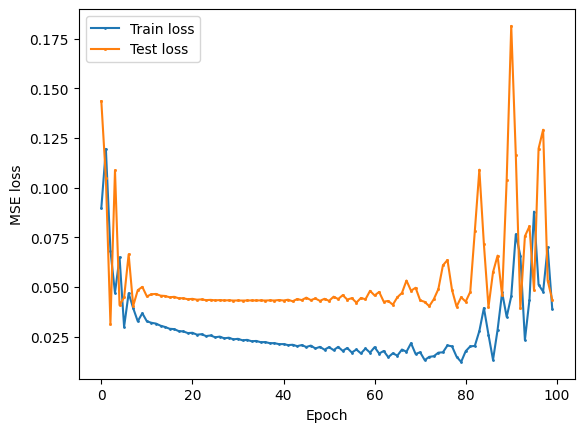

In [9]:
def loss_list():
    plt.plot(dast_model.train_loss_list, label='Train loss', marker='o', markersize=1)
    plt.plot(dast_model.test_loss_list, label='Test loss', marker='s', markersize=1)
    plt.xlabel('Epoch')
    plt.ylabel('MSE loss')
    plt.legend()
    plt.show()
loss_list()

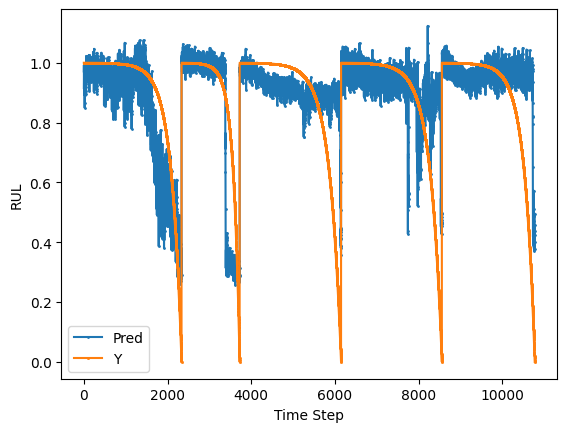

In [10]:
def best_predict():
    plt.plot(dast_model.best_predict, label='Pred', marker='o', markersize=1)
    plt.plot(y, label='Y', marker='s', markersize=1)
    plt.xlabel('Time Step')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()
best_predict()

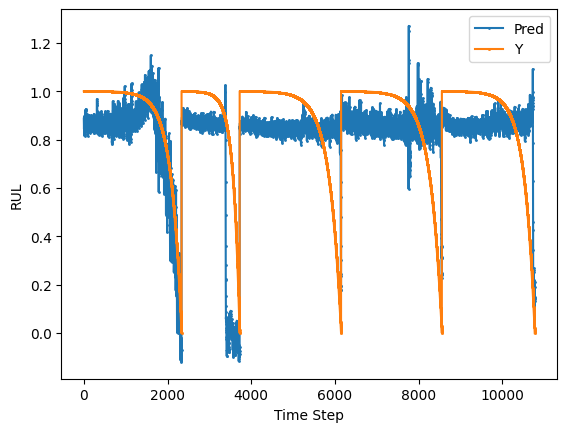

In [11]:
def last_predict_vs_y():
    last_predict_y = np.reshape(dast_model.last_predict_y, (-1))
    last_predict_y = last_predict_y.tolist()
    plt.plot(last_predict_y, label='Pred', marker='o', markersize=1)
    plt.plot(y, label='Y', marker='s', markersize=1)
    plt.xlabel('Time Step')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()
last_predict_vs_y()

In [12]:
print(f"{dast_model.best_train_loss:.7f}")
print(f"{dast_model.best_mse_loss:.7f}")
print(f"{dast_model.best_rmse_loss:.7f}")


0.0122001
0.0315154
0.1775259


In [ ]:
# run above